In [1]:
import rasterio
import tqdm
import leafmap
import geopandas as gpd
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import concurrent.futures
from mpire import WorkerPool
from skimage.restoration import denoise_tv_bregman
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.var import VAR

# Setup

In [2]:
BURST_ID = 'T126-269585-IW2'

In [3]:
df_rtc = pd.read_json('../4_rtc_organization/rtc_s1_table.json.zip')
df_rtc.head()

,rtc_s1_id,input_slc_id,jpl_burst_id,bursts_per_slc_input,rtc_s1_vv_url,rtc_s1_vh_url,rtc_s1_h5_url,acq_datetime
0,OPERA_L2_RTC-S1_T005-008688-IW2_20201010T00400...,S1A_IW_SLC__1SDV_20201010T004001_20201010T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-10 00:40:01
1,OPERA_L2_RTC-S1_T005-008688-IW2_20201022T00400...,S1A_IW_SLC__1SDV_20201022T004000_20201022T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-22 00:40:00
2,OPERA_L2_RTC-S1_T005-008688-IW2_20201103T00400...,S1A_IW_SLC__1SDV_20201103T004000_20201103T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-11-03 00:40:00
3,OPERA_L2_RTC-S1_T005-008688-IW2_20201115T00400...,S1A_IW_SLC__1SDV_20201115T004000_20201115T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-11-15 00:40:00
4,OPERA_L2_RTC-S1_T005-008688-IW2_20201127T00400...,S1A_IW_SLC__1SDV_20201127T004000_20201127T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-11-27 00:40:00


In [4]:
df_rtc_ts = df_rtc[df_rtc.jpl_burst_id == BURST_ID].reset_index(drop=True)


In [5]:
def open_one(path: str) -> tuple:
    with rasterio.open(path) as ds:
        X = ds.read(1)
        p = ds.profile
    X = np.clip(X, 0, 1)
    return (X), p

def normalize_pol_ratio(img: np.ndarray, max_factor: float = 4.):
    vmax = max_factor
    vmin = 1e-7
    
    img_out = img.copy()
    img_out = np.clip(img_out, vmin, vmax)

    img_out = (img_out - vmin) / (vmax - vmin)    
    return img_out
    

def despeckle_one(X: np.ndarray, reg_param=2, noise_floor_db = -22) -> np.ndarray:
    X_c = np.clip(X, 1e-7, 1)
    X_db = 10 * np.log10(X_c, out=np.full(X_c.shape, np.nan), where=(~np.isnan(X_c)))
    X_db[np.isnan(X_c)] = noise_floor_db
    X_db_dspkl = denoise_tv_bregman(X_db, weight=.25, isotropic=True, eps=1e-3)
    X_dspkl = np.power(10, X_db_dspkl / 10.)
    X_dspkl[np.isnan(X)] = np.nan
    X_dspkl = np.clip(X_dspkl, 0, 1)
    return X_dspkl

In [6]:
K = 20

with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    data = list(tqdm(executor.map(open_one, df_rtc_ts.rtc_s1_vv_url[:K]), total=K))
arrs_vv, profiles = zip(*data)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.10it/s]


In [7]:
with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    data = list(tqdm(executor.map(open_one, df_rtc_ts.rtc_s1_vh_url[:K]), total=K))
arrs_vh, _ = zip(*data)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:29<00:00,  1.48s/it]


In [8]:
with WorkerPool(n_jobs=10, use_dill=True) as pool:
    arrs_vv_d = pool.map(despeckle_one,
                         arrs_vv, 
                         progress_bar=True, 
                         progress_bar_style='notebook', 
                         concatenate_numpy_output=False)

  0%|                                                                                                         …

In [9]:
with WorkerPool(n_jobs=10, use_dill=True) as pool:
    arrs_vh_d = pool.map(despeckle_one, 
                         arrs_vh, 
                         progress_bar=True, 
                         progress_bar_style='notebook', 
                         concatenate_numpy_output=False)

  0%|                                                                                                         …

In [10]:
data_pixels = (~np.isnan(arrs_vh_d)).sum()
f'{data_pixels:,d}'

'40,883,739'

## Patch Setup

In [11]:
df_patch_all = pd.read_json('../6_torch_dataset/dist_s1_patch_lut.json.zip')
df_patch_all.head()

,x_start,x_stop,y_start,y_stop,epsg,jpl_burst_id
0,2960,3184,200,424,32614,T005-008688-IW2
1,2980,3204,200,424,32614,T005-008688-IW2
2,3000,3224,200,424,32614,T005-008688-IW2
3,3020,3244,200,424,32614,T005-008688-IW2
4,2860,3084,220,444,32614,T005-008688-IW2


In [12]:
df_patches = df_patch_all[df_patch_all.jpl_burst_id == BURST_ID].reset_index(drop=True)
df_patches.head()

,x_start,x_stop,y_start,y_stop,epsg,jpl_burst_id
0,320,544,160,384,32723,T126-269585-IW2
1,280,504,180,404,32723,T126-269585-IW2
2,300,524,180,404,32723,T126-269585-IW2
3,320,544,180,404,32723,T126-269585-IW2
4,340,564,180,404,32723,T126-269585-IW2


In [13]:
J = 500
patches = df_patches.to_dict('records')
r = patches[J]

sy = np.s_[r['y_start']: r['y_stop']]
sx = np.s_[r['x_start']: r['x_stop']]



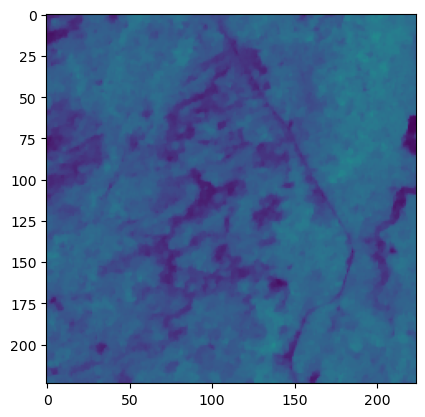

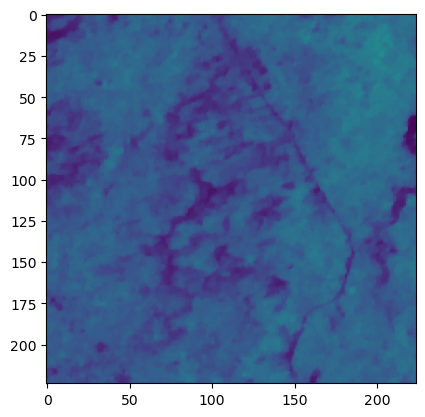

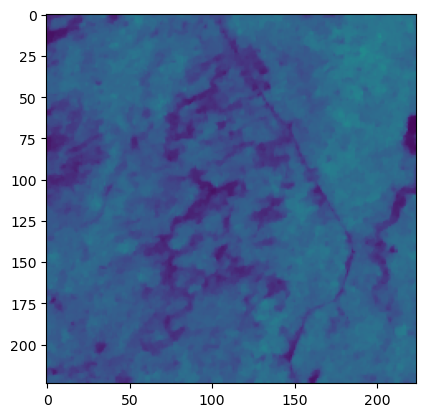

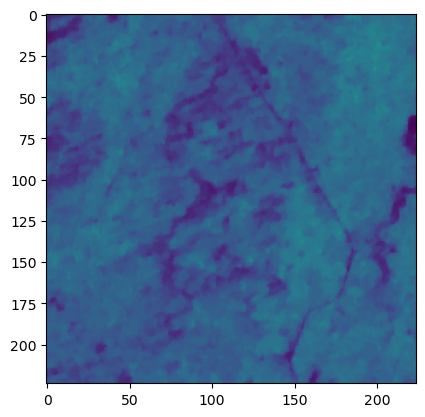

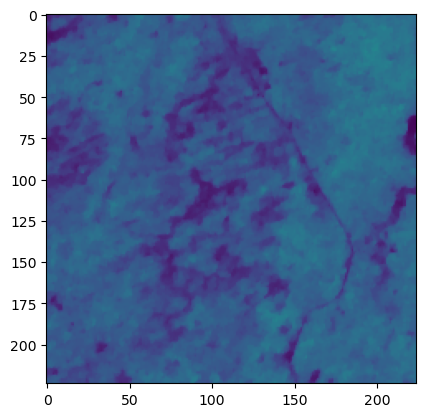

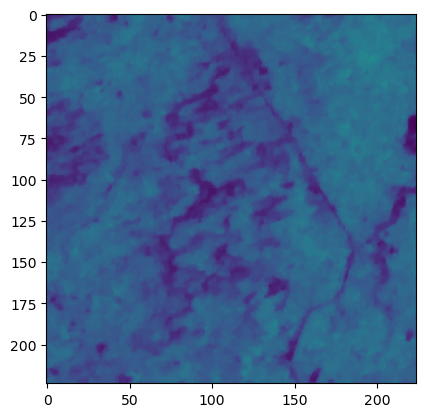

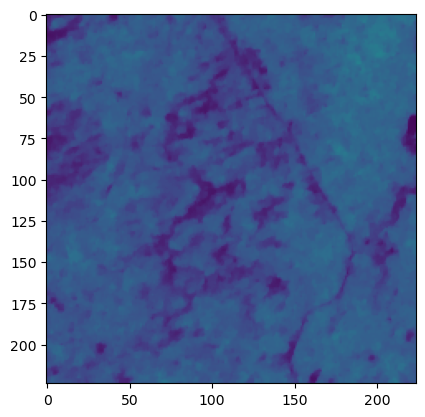

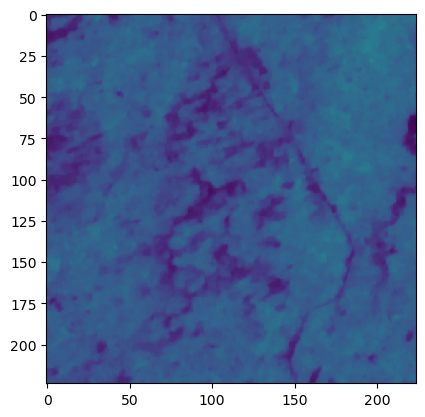

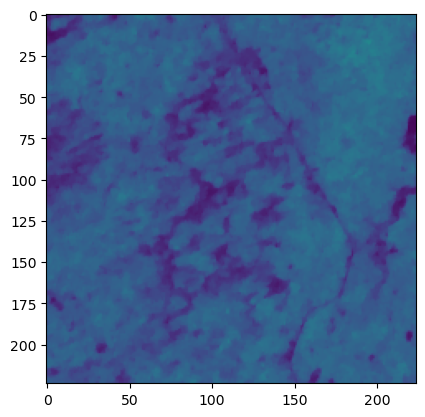

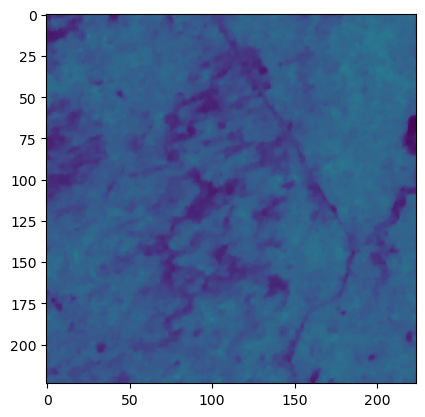

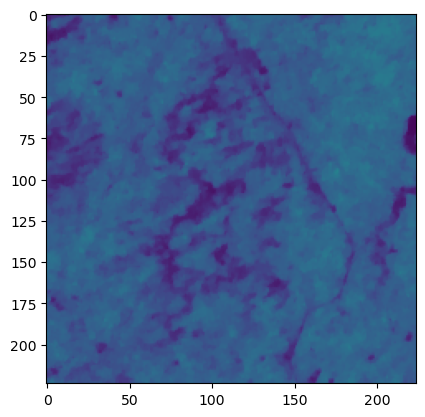

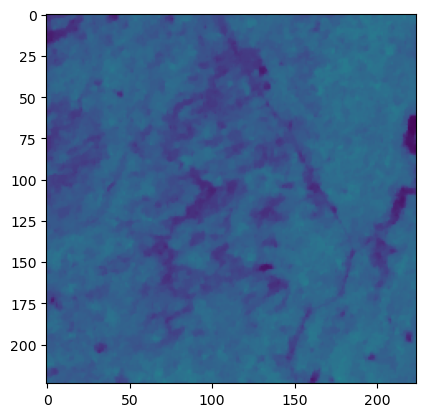

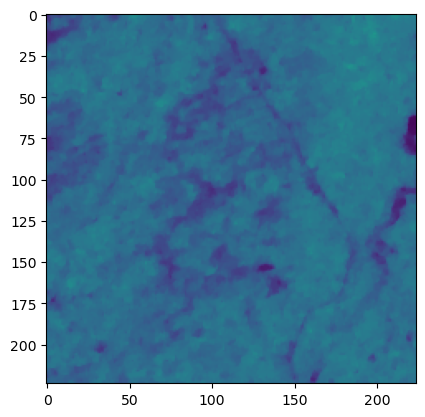

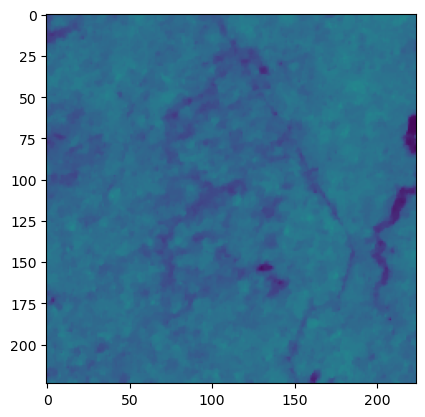

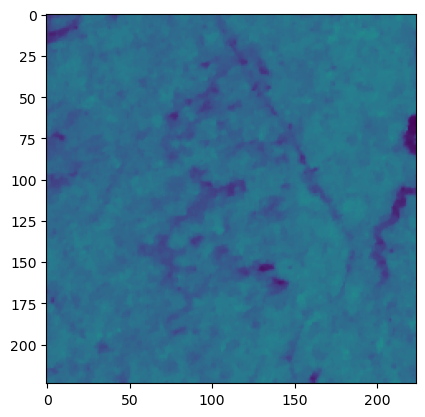

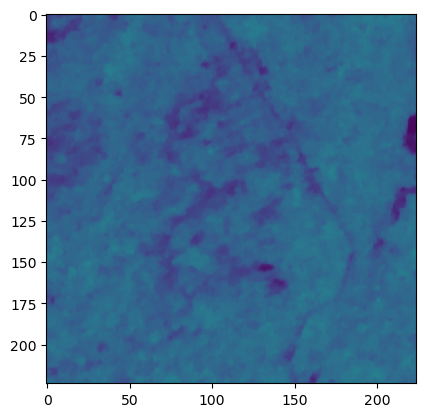

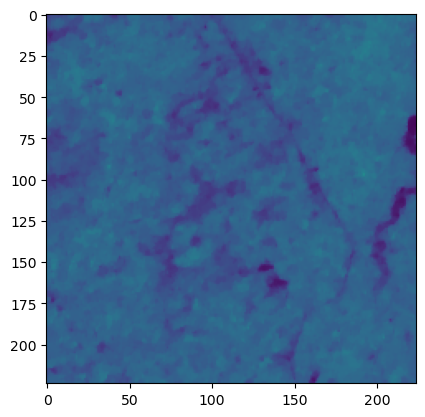

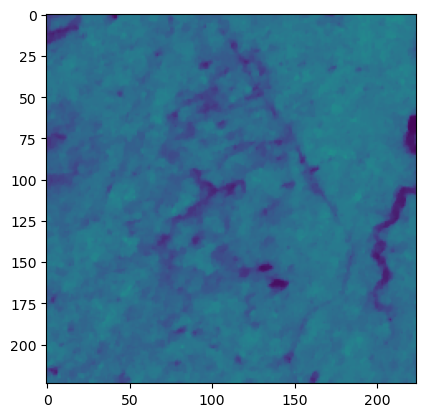

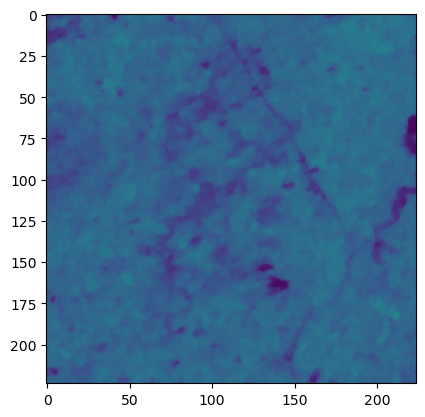

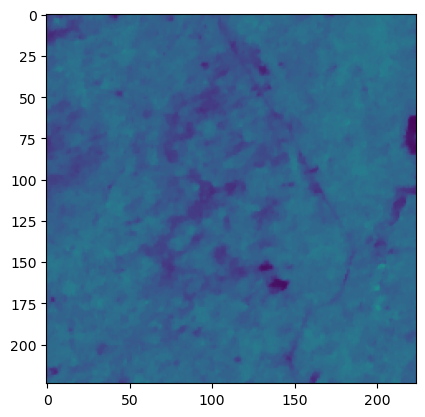

In [14]:
for X in arrs_vh_d:
    plt.figure()
    plt.imshow(X[sy, sx], vmin=0, vmax=.15)
    plt.show()
    plt.close() 

# Time Series Setup

In [15]:
vv_point = [vv[sy, sx][112, 112] for vv in arrs_vv_d]
vh_point = [vh[sy, sx][112, 112] for vh in arrs_vh_d]

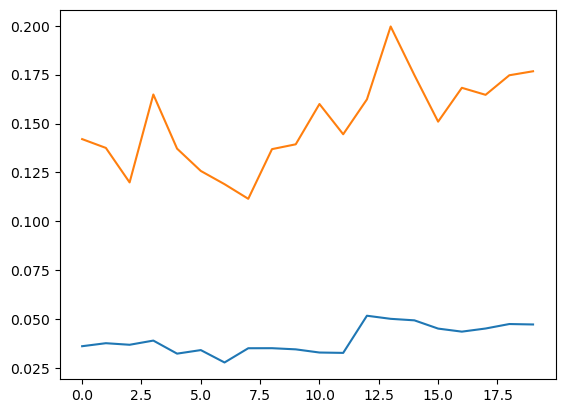

In [16]:
plt.plot(vh_point)
plt.plot(vv_point)

In [17]:
dts_raw = pd.to_datetime(df_rtc_ts.acq_datetime.tolist())
dts_all = [dt.round('D') for dt in dts_raw]
dts_all[:K]

[Timestamp('2020-10-06 00:00:00'),
 Timestamp('2020-10-18 00:00:00'),
 Timestamp('2020-10-30 00:00:00'),
 Timestamp('2020-11-11 00:00:00'),
 Timestamp('2020-11-23 00:00:00'),
 Timestamp('2020-12-05 00:00:00'),
 Timestamp('2020-12-29 00:00:00'),
 Timestamp('2021-01-10 00:00:00'),
 Timestamp('2021-01-22 00:00:00'),
 Timestamp('2021-02-03 00:00:00'),
 Timestamp('2021-02-15 00:00:00'),
 Timestamp('2021-02-27 00:00:00'),
 Timestamp('2021-03-11 00:00:00'),
 Timestamp('2021-03-23 00:00:00'),
 Timestamp('2021-04-04 00:00:00'),
 Timestamp('2021-04-16 00:00:00'),
 Timestamp('2021-04-28 00:00:00'),
 Timestamp('2021-05-10 00:00:00'),
 Timestamp('2021-05-22 00:00:00'),
 Timestamp('2021-06-03 00:00:00')]

In [18]:
df_train = pd.DataFrame(data={'vv': vv_point,
                              'vh': vh_point
                             },
                       index=dts_all[:K]).resample('12D').ffill()
df_train.head()

,vv,vh
2020-10-06,0.142041,0.036160
2020-10-18,0.137534,0.037699
2020-10-30,0.119897,0.036895
2020-11-11,0.164849,0.039037
2020-11-23,0.137165,0.032362


In [19]:
model_var = VAR(trend='ct') 
model_p = Prophet(seasonality_mode='additive',
                               yearly_seasonality=False, 
                               growth='linear', 
                               daily_seasonality=False, 
                               weekly_seasonality=False
                              )

model_var.fit(df_train)  
y_pred = model_p.fit(df_train[['vv']])
y_pred_vv_p = model_p.predict(fh=[1,2,3])

y_pred =  model_var.predict(fh=[1, 2, 3])
y_pred

09:43:15 - cmdstanpy - INFO - Chain [1] start processing
09:43:15 - cmdstanpy - INFO - Chain [1] done processing


,vv,vh
2021-06-15,0.179004,0.048429
2021-06-27,0.182594,0.049438
2021-07-09,0.185774,0.050391


(18541.0, 18823.0)

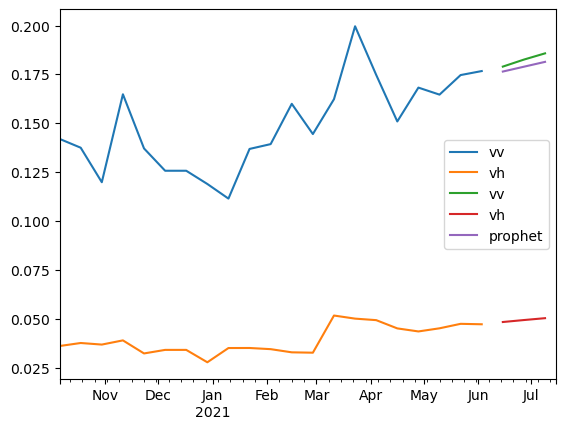

In [20]:
ax = df_train.plot()
y_pred.plot(ax=ax)

ax.plot(y_pred_vv_p, label='prophet')
plt.legend()
ax.set_xlim(df_train.index.min(), y_pred.index.max() + pd.Timedelta(days=6))


In [21]:
y_pred_vv_p

,vv
2021-06-15,0.176475
2021-06-27,0.178950
2021-07-09,0.181426


In [22]:
# %%timeit
# model_p = Prophet(seasonality_mode='additive',
#                            yearly_seasonality=False, 
#                            growth='linear', 
#                            daily_seasonality=False, 
#                            weekly_seasonality=False
#                           )

# model_p.fit(df_train)
# y_pred_quantiles = model_p.predict_quantiles(fh=[1], 
#                                              #alpha=[n/100 for n in b + u]
#                                             )

In [23]:
# proc_hours_per_pol = int( data_pixels * 1 / 1000. / 60 ) 
# f'{proc_hours_per_pol:,d}'

In [24]:
# def func(x: int):
#     model_p = Prophet(seasonality_mode='additive',
#                                yearly_seasonality=False, 
#                                growth='linear', 
#                                daily_seasonality=False, 
#                                weekly_seasonality=False
#                               )

#     model_p.fit(df_train)
#     y_pred_quantiles = model_p.predict_quantiles(fh=[1], 
#                                                  alpha=[n/100 for n in b + u])
#     return y_pred

In [25]:
# with WorkerPool(n_jobs=100, use_dill=True) as pool:
#     out = pool.map(func, range(1_000), 
#                          progress_bar=True, 
#                          progress_bar_style='notebook', 
#                          concatenate_numpy_output=False)

In [26]:

y_pred_quantiles = model_p.predict_quantiles(fh=[1], 
                                             alpha=[n/100 for n in b + u])


NameError: name 'b' is not defined

In [ ]:
y_pred_quantiles['vv', .05]

In [ ]:
y_pred_quantiles

In [ ]:
ax = df_train.plot()
ax.fill_between(y_pred_quantiles.index, y_pred_quantiles['vv', .01], y_pred_quantiles['vv', .99], alpha=.5, color='blue')
ax.plot(y_pred_vv_p)
ax.set_xlim(df_train.index.min(), y_pred.index.max() + pd.Timedelta(days=6))
ax.set_ylim(.1, .5)